In [31]:
from sklearn.ensemble import (RandomForestRegressor, IsolationForest)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import numpy as np
import pandas as pd
import ml_helper as ml

In [32]:
# load housing data
iowa_file_path = '../data/train.csv'
home_data = pd.read_csv(iowa_file_path)
Y = home_data["SalePrice"]
X = home_data.drop(columns = ["Id"])


In [33]:
# columsns to drop
columns_to_ignore = ["Id", "1stFlrSF", "2ndFlrSF", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]

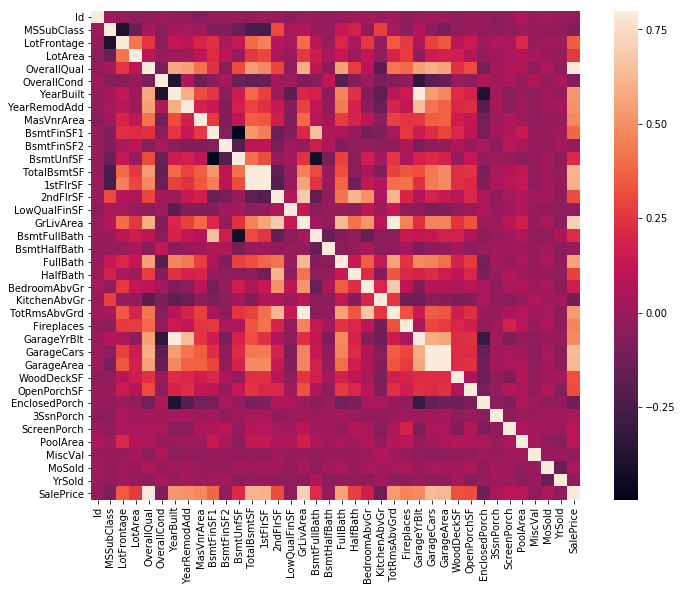

In [34]:
ml.plotHeatmap(home_data)

In [23]:
home_data["KitchenAbvGr"].value_counts()


1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [ ]:
home_data.info()

In [ ]:
home_data[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]]

In [ ]:
columnsWithMissingData(X, threshold = 0.5)

In [ ]:
# We will train our classifier with the following features:

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = X_train.select_dtypes(exclude=object) 
num_features_names = numeric_features.columns

# features that need a log transformation
log_features_names = ["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea", "OpenPorchSF"]

log_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', FunctionTransformer(np.log1p, validate=False)),
    ('logscaler', StandardScaler())])

#kbinDiscretizer features
year_features_names = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
year_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('kbd', KBinsDiscretizer(n_bins=5, encode='onehot-dense'))])

#numeric features that require a normal transformation

numeric_features_names = [x for x in num_features_names if x not in log_features_names + year_features_names]
print(len(numeric_features_names))

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features_names = X_train.select_dtypes(include=object).columns

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformers=[
        ('log', log_pipeline, log_features_names),
        ('num', numeric_pipeline, numeric_features_names),
        ('cat', cat_pipeline, categorical_features_names),
        ('year', year_pipeline, year_features_names)     
    ]

ct = ColumnTransformer(transformers=transformers)
Xt = ct.fit_transform(X_train)
print(Xt.shape)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', RandomForestRegressor(random_state=1, n_estimators = 500, criterion="mae"))
                     ])



In [ ]:
#fitting and prediction
clf.fit_transform(X_train, y_train)
y_predict = clf.predict(X_test)
rf_val_mae = mean_absolute_error(y_test, y_predict)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

#train the best model on the full dat
clf.fit(X,Y)

#path to file you will use for predictions
test_data_path = '../data/test.csv'
test_data = pd.read_csv(test_data_path)

X_test2 = test_data.drop(columns = ["Id"])

#make predictions which we will submit. 
y_pred2 = clf.predict(X_test2)

#The lines below shows how to save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': y_pred2})
output.to_csv('../data/submission.csv', index=False)